In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import pearsonr
from scipy.stats import linregress
from scipy.optimize import curve_fit
from pymer4.models import Lmer
import math
import re
from scipy import optimize
import pwlf
from sklearn.metrics import r2_score
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

In [2]:
def month_saved(data):
    m,n = data.shape
    month_sa = []
    for i in range(12):
        T = []
        for j in range(m):
            if j%12 == i and data['TA_F_MDS'][j] != -9999:
                T.append(data['TA_F_MDS'][j])
        if np.mean(T) >= 0:
            month_sa.append(i+1)
    return month_sa

In [3]:
path1 = 'D:/Data/Fluxnet/AllHourlyData_year3/FLX_FR-Fon_FLUXNET2015_FULLSET_HH_2005-2014_1-4.csv'
path2 = 'D:/Data/Fluxnet/monthly_data/FLX_FR-Fon_FLUXNET2015_FULLSET_MM_2005-2014_1-4.csv'

data1 = pd.read_csv(path1)
data2 = pd.read_csv(path2)
month_sa = month_saved(data2)

m,n = data1.shape
month = np.round(data1['TIMESTAMP_START']/1000000).astype(int)%100

normalized_T_all = []
ln_R_all = []

normalized_T_all_one = []
ln_R_all_one = []

days1 = 10

days2 = 5

for i in range(int(m/48/days1)-30, int(m/48/days1)-17):
    
    a = month[i*days1*48 : i*days1*48+days2*48]
    print(month[i*days1*48])
    b = np.array(month_sa)
    if np.in1d(a, b).all():
        Ti_0 = data1['TA_F_MDS'].values[i*days1*48 : i*days1*48+days2*48]
        VPDi_0 = data1['VPD_F_MDS'].values[i*days1*48 : i*days1*48+days2*48]
        RECOi_0 = data1['RECO_NT_VUT_REF'].values[i*days1*48 : i*days1*48+days2*48]
        T_QCi_0 = data1['VPD_F_MDS_QC'].values[i*days1*48 : i*days1*48+days2*48]
        VPD_QCi_0 = data1['VPD_F_MDS_QC'].values[i*days1*48 : i*days1*48+days2*48]
                                    
        Ti_1 = Ti_0[(Ti_0!=-9999) & (VPDi_0!=-9999) & (RECOi_0!=-9999) & (RECOi_0>0.01) & (T_QCi_0==0) & (VPD_QCi_0==0) & (Ti_0>0)]
        VPDi_1 = VPDi_0[(Ti_0!=-9999) & (VPDi_0!=-9999) & (RECOi_0!=-9999) & (RECOi_0>0.01) & (T_QCi_0==0) & (VPD_QCi_0==0) & (Ti_0>0)]
        RECOi_1 = RECOi_0[(Ti_0!=-9999) & (VPDi_0!=-9999) & (RECOi_0!=-9999) & (RECOi_0>0.01) & (T_QCi_0==0) & (VPD_QCi_0==0) & (Ti_0>0)]
                                    
        
        
        Normal_Ti_1 = (Ti_1-10)/10
        ln_RECOi_1 = np.log(RECOi_1)
        
        normalized_T_all.append(Normal_Ti_1.tolist())
        ln_R_all.append(ln_RECOi_1.tolist())
        
        normalized_T_all_one+=Normal_Ti_1.tolist()
        ln_R_all_one+=ln_RECOi_1.tolist()

3
3
3
4
4
4
5
5
5
6
6
6
7


[0.47883716 0.68572691]


Text(0.05, 0.95, 'FR-Fon')

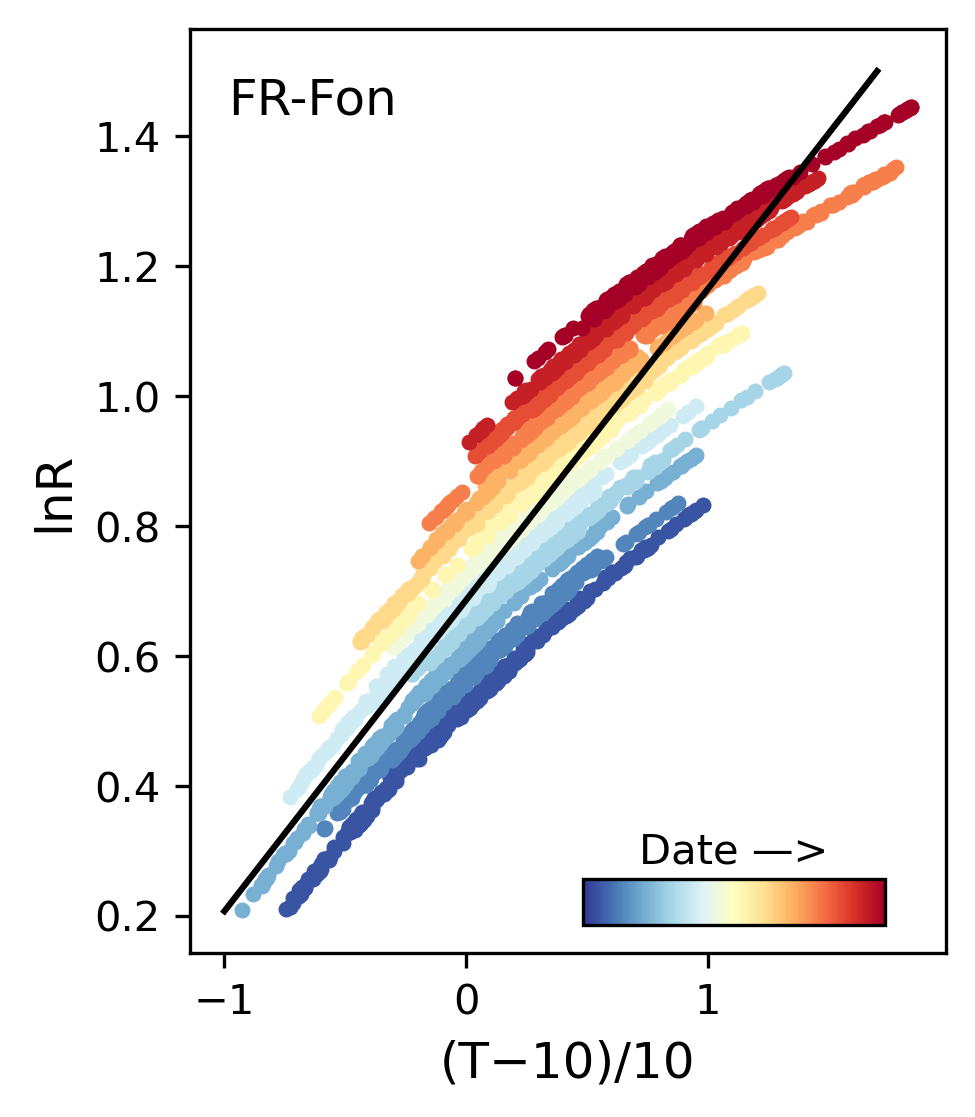

In [4]:
fig = plt.figure(figsize=(13*1/4, 4),dpi=300)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.3)
plt.rcParams['axes.linewidth'] = 0.8

ax = fig.add_subplot(1,1,1)
ax_pos = ax.get_position()
x1 = ax_pos.x0
y1 = ax_pos.y0
width1 = ax_pos.width
height1 = ax_pos.height
cax = fig.add_axes([x1+0.52*width1, y1+0.03*height1, 0.4*width1, 0.05*height1])  #四个参数分别是colorbar的左、下、宽、长 
cbar = mpl.colorbar.ColorbarBase(cax, cmap='RdYlBu_r',#颜色
                                  norm=mpl.colors.Normalize(-1,1),#设置颜色条最大最小值
                                  ticks=list(np.linspace(-1, 1, 5)),#自定义各段的记号
                                  orientation='horizontal', #方向垂直
                                  label = 'Date —>');
cbar.ax.xaxis.set_label_position('top') # 移动colorbar的标签到顶部
cbar.ax.tick_params(direction='in', bottom = False, top = True, labelbottom = False, labeltop = True, length=0, colors='k') # 设置标签样式
cbar.ax.tick_params(labelsize=10)
cbar.set_ticks([])

sm = plt.cm.ScalarMappable(norm=cbar.norm, cmap=cbar.cmap)

colors = []
for i in range(len(normalized_T_all)):
    value = -0.9+i*0.16
    color = sm.to_rgba(value)
    colors.append(color)

for i in range(len(normalized_T_all)):
    ax.scatter(normalized_T_all[i], ln_R_all[i], s=8, marker='o', color=colors[i])

    
x = normalized_T_all_one
y = ln_R_all_one
coefficients = np.polyfit(normalized_T_all_one, ln_R_all_one, 1)
p = np.poly1d(coefficients)
print(coefficients)

x_plot = np.arange(-1,1.8,0.1)
ax.plot(x_plot, p(x_plot), color='black', linewidth=1.5)

#ax.legend(fontsize=10, edgecolor='white', loc='upper left', frameon=True, handlelength = 2)
#ax.set_xticklabels([])
#ax.set_yticklabels([])
#ax.set_xticks([])
#ax.set_yticks([])
ax.set_xlabel('(T\u221210)/10',size = 12)
ax.set_ylabel('lnR',size = 12)
ax.text(0.05, 0.95, "FR-Fon", transform=ax.transAxes,
         fontsize=12, fontweight='normal', va='top', ha='left')


In [11]:
coefficients

array([0.47883716, 0.68572691])

In [12]:
np.exp(0.47883716)

1.6141962584370249

In [13]:
np.exp(0.68572691)

1.9852143833598292